In [1]:
%matplotlib inline
import matplotlib.pyplot as plt                        # To create plots
import numpy as np                                     # To perform calculations quickly
import pandas as pd                                    # To load in and manipulate data
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB          # Naive bayes model
from sklearn.model_selection import train_test_split   # Split up the data in a train and test set
from sklearn.metrics import confusion_matrix,classification_report,roc_curve
from ipywidgets import interact,widgets                # For interactive execution of code

In [2]:
# Read in the data and show the first lines
data = pd.read_csv("../data/unbalanced_dataset.csv",sep=";",decimal=',')
data.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f22,f23,f24,f25,f26,f27,f28,f29,f30,target
0,1,1,17.2131,1,1,1,3,2,3,1,...,2250,1,1,1,9,1,40,13,32.766370,0
1,2,35,0.1747,1,1,2,1,1,2,2,...,3488,1,1,1,10,1,12,23,210.567669,0
2,3,1,4.4873,1,1,1,1,1,2,1,...,4050,1,1,1,9,1,36,7,9.380889,0
3,4,2,55.1508,2,1,4,8,2,2,1,...,2700,1,1,1,9,1,36,11,20.445923,1
4,5,10,0.0771,1,1,1,3,2,3,1,...,2970,1,1,1,12,1,36,10,36.247242,0


In [3]:
# Id is uninformative, so let's drop it
data.drop("id",axis=1,inplace=True)

<Axes: xlabel='target', ylabel='count'>

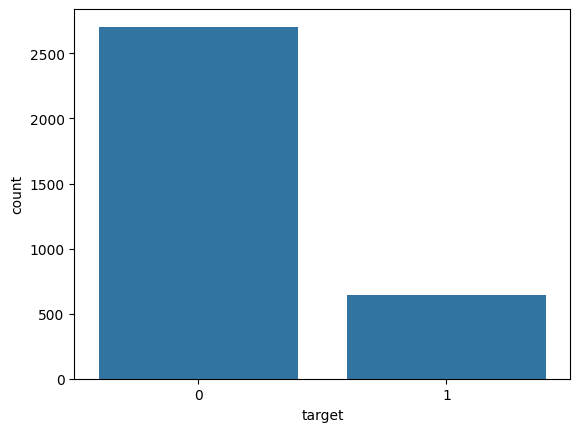

In [4]:
# Take a look at the distribution of the classes (target column)
sns.countplot(x=data.target)

In [5]:
# Split into features and targets
X=data.drop("target",axis=1)
y=data.target

# Split into training and testing set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [6]:
# Create a logistic regression model
model=LogisticRegression(max_iter=10000)
# Fit the model on our training data
model.fit(X_train,y_train)

# Print the score of the test set
print(model.score(X_test,y_test))

# Predict the classes of the test set
y_pred=model.predict(X_test)

#Print confusion matrix and classification report
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.8009950248756219
[[804   1]
 [199   1]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       805
           1       0.50      0.01      0.01       200

    accuracy                           0.80      1005
   macro avg       0.65      0.50      0.45      1005
weighted avg       0.74      0.80      0.71      1005



## Discussion
As we can see in the example above, almost all our test cases are classified as class '0'. 

This is due to the majority of our test cases being of class '0'. When classifying everything as class '0' you are already +80% correct!

How can we solve this?

- Add more samples of class '1' (collect more data)
- Take only a subset of all class '0' samples so they correspond almost equally  (Undersampling)
- Duplicate samples of class '1'  (Oversampling)
- Choose another scoring system (e.g. f1-score)
- Class-weight balancing
- Data augmentation (e.g. SMOTE, ADASYN)

Interesting to read:

- https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb
- https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

<div><img src="../images/under_over_sampling.jpg" width="700"/></div>

---
<div><img src="../images/data_augmentation.png" width="500"/></div>

A few of the techniques will be shown below. Feel free to try other techniques yourself

### Undersampling

A simple example of undersampling. Better ways exist, but generally this is not used.

Training length class 0: 1900, Training length class 1: 442


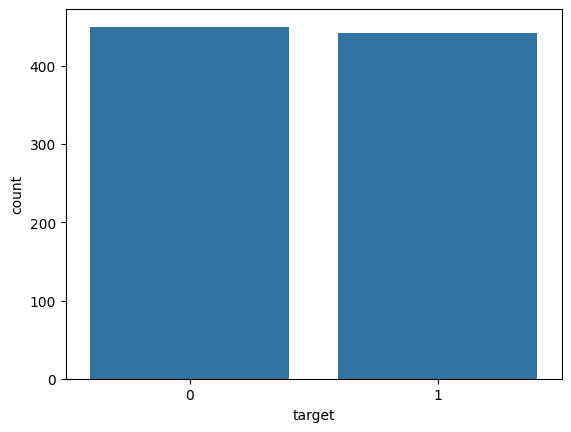

0.6139303482587065
[[516 289]
 [ 99 101]]
              precision    recall  f1-score   support

           0       0.84      0.64      0.73       805
           1       0.26      0.51      0.34       200

    accuracy                           0.61      1005
   macro avg       0.55      0.57      0.53      1005
weighted avg       0.72      0.61      0.65      1005



/home/guest/miniconda3/envs/bit07/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
print(f"Training length class 0: {sum(y_train==0)}, Training length class 1: {sum(y_train==1)}")

# Take a subset of the training samples of class 0 based on the number of samples of class 1
X_train_subset_class0 = X_train[y_train==0].iloc[:450]
y_train_subset_class0 = y_train[y_train==0].iloc[:450]

# Also take all class 1 samples
X_train_class1 = X_train[y_train==1]
y_train_class1 = y_train[y_train==1]

# Combine them back into one dataframe (with same number of samples of class 0 and 1, in this case 454 for each)
X_train_subset=pd.concat([X_train_subset_class0,X_train_class1])
y_train_subset=pd.concat([y_train_subset_class0,y_train_class1])

# Since our dataframes are now stuck together with first all class 0 samples, and then all class 1 samples, let's shuffle
# them randomly
from sklearn.utils import shuffle
X_train_subset,y_train_subset = shuffle(X_train_subset,y_train_subset)

# Show the new data distribution
sns.countplot(x=y_train_subset)
plt.show()

# Train our model again on this subset
model=LogisticRegression(max_iter=10000)
model.fit(X_train_subset,y_train_subset)

print(model.score(X_test,y_test))

y_pred=model.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

### Oversampling
Let's try oversampling instead, note that this is also not the best way. There are modules that can do random oversampling. However, since this is not used a lot, we don't use it here. This is more an example of how this could be done.

Training length class 0: 1900, Training length class 1: 442


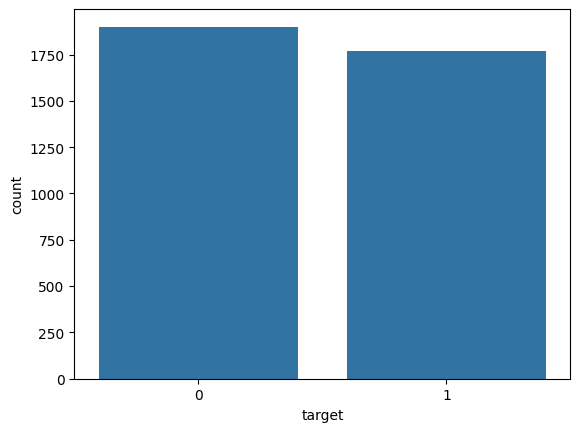

0.6517412935323383
[[553 252]
 [ 98 102]]
              precision    recall  f1-score   support

           0       0.85      0.69      0.76       805
           1       0.29      0.51      0.37       200

    accuracy                           0.65      1005
   macro avg       0.57      0.60      0.56      1005
weighted avg       0.74      0.65      0.68      1005



In [8]:
print(f"Training length class 0: {sum(y_train==0)}, Training length class 1: {sum(y_train==1)}")

# Take all class 1 samples
X_train_class1 = X_train[y_train==1]
y_train_class1 = y_train[y_train==1]

# Since there are approximately 4 times as much class '0' samples, we can just add out class 1 values 3 times to the
# bottom of the dataset (1 is already in there, so 1+3 times class '1')
X_train_oversampled=pd.concat([X_train,X_train_class1,X_train_class1,X_train_class1])
y_train_oversampled=pd.concat([y_train,y_train_class1,y_train_class1,y_train_class1])

# Also shuffle them (bottom 1350-ish samples are of class '1')
from sklearn.utils import shuffle
X_train_oversampled,y_train_oversampled = shuffle(X_train_oversampled,y_train_oversampled)

# Show the new data distribution
sns.countplot(x=y_train_oversampled)
plt.show()

# Train our model again on this subset
model=LogisticRegression(max_iter=10000)
model.fit(X_train_oversampled,y_train_oversampled)

print(model.score(X_test,y_test))

y_pred=model.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

### Class-weight balancing
We can make errors for predicting the smaller class (in this case class 1) a higher impact on the score.

If our dataset would be 9/10 class '0' and 1/10 class '1'. We could say: if the prediction of class '1' is wrong => do the error * 9 

This is the technique that is mostly used


In [9]:
#Let the model decide by itself
model=LogisticRegression(max_iter=10000,class_weight="balanced")
model.fit(X_train,y_train)

print(model.score(X_test,y_test))

y_pred=model.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.6049751243781094
[[494 311]
 [ 86 114]]
              precision    recall  f1-score   support

           0       0.85      0.61      0.71       805
           1       0.27      0.57      0.36       200

    accuracy                           0.60      1005
   macro avg       0.56      0.59      0.54      1005
weighted avg       0.74      0.60      0.64      1005



In [10]:
# Define weights ourself
model=LogisticRegression(max_iter=10000,class_weight={0:1,1:4}) # You can also provide it as a list, in same order as the 
                                                                # classes: [1,4], here, class 0 will have a weight of one,
                                                                # And class 1 a weight of four. 
model.fit(X_train,y_train)

print(model.score(X_test,y_test))

y_pred=model.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.6517412935323383
[[553 252]
 [ 98 102]]
              precision    recall  f1-score   support

           0       0.85      0.69      0.76       805
           1       0.29      0.51      0.37       200

    accuracy                           0.65      1005
   macro avg       0.57      0.60      0.56      1005
weighted avg       0.74      0.65      0.68      1005

